# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.4 louvain==0.7.0


In [3]:
results_file = 'write/SCP1214.h5ad'  # the file that will store the analysis results

In [259]:
D4_exon = sc.read_10x_mtx(
    'data/CellRanger6/exon/02',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-CellRanger6-exon-02-matrix.h5ad


In [260]:
D8_exon = sc.read_10x_mtx(
    'data/CellRanger6/exon/04',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-CellRanger6-exon-04-matrix.h5ad


In [261]:
D4_premrna = sc.read_10x_mtx(
    'data/CellRanger6/premrna/02',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-CellRanger6-premrna-02-matrix.h5ad


In [262]:
D8_premrna = sc.read_10x_mtx(
    'data/CellRanger6/premrna/04',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-CellRanger6-premrna-04-matrix.h5ad


In [169]:
metadata_kidney

,NAME,n_genes,n_UMI,percent_mito,method,doublet,predicted_celltype,manual_annotation,donor,disease
1,02-P248880-S026-R01-AGACAGGCATGCCGAC,5135,19926,0.00,nuclei,True,podocyte,Podocyte,D5,COVID-19
2,02-P248880-S026-R01-GGTGGCTGTATGGAAT,5236,17399,0.00,nuclei,False,parietel_epithelial,tDL,D5,COVID-19
3,02-P248880-S026-R01-GTTGTCCAGGGAGGAC,4661,16131,0.00,nuclei,False,podocyte,Podocyte,D5,COVID-19
4,02-P248880-S026-R01-GTTACGATCCCTTGGT,4321,14082,0.00,nuclei,False,podocyte,Podocyte,D5,COVID-19
5,02-P248880-S026-R01-CAACCTCCACGAAAGC,4147,13239,9.62,nuclei,False,parietel_epithelial,PCT-S1/S2,D5,COVID-19
...,...,...,...,...,...,...,...,...,...,...
33868,13-P999994-S001-R01-CTACTATCACCCATAA,329,403,0.00,nuclei,False,princial_collecting_duct,CNT,D28,COVID-19
33869,13-P999994-S001-R01-CTAACCCGTAGGAGTC,316,405,0.00,nuclei,False,princial_collecting_duct,CNT,D28,COVID-19
33870,13-P999994-S001-R01-GTTACGATCCAATCTT,330,404,0.00,nuclei,False,collecting_duct_alpha,CD-IC-A,D28,COVID-19
33871,13-P999994-S001-R01-CTACAGATCCACGTGG,314,401,0.00,nuclei,False,collecting_duct_alpha,CD-IC-B,D28,COVID-19


In [263]:
D4_only = metadata_kidney[metadata_kidney['donor'] == 'D4']['NAME'].tolist()
D8_only = metadata_kidney[metadata_kidney['donor'] == 'D8']['NAME'].tolist()

In [265]:
temp4 = D4_exon.obs.index.tolist()
for i in range(len(temp4)):
    temp4[i] = '02-P240970-S036-R01-' + temp4[i].removesuffix('-1')
D4_exon.obs.index = temp4

In [267]:
temp8 = D8_exon.obs.index.tolist()
for i in range(len(temp8)):
    temp8[i] = '04-P006354-S023-R01-' + temp8[i].removesuffix('-1')
D8_exon.obs.index = temp8

In [268]:
temp4p = D4_premrna.obs.index.tolist()
for i in range(len(temp4p)):
    temp4p[i] = '02-P240970-S036-R01-' + temp4p[i].removesuffix('-1')
D4_premrna.obs.index = temp4p

In [269]:
temp8p = D8_premrna.obs.index.tolist()
for i in range(len(temp8p)):
    temp8p[i] = '04-P006354-S023-R01-' + temp8p[i].removesuffix('-1')
D8_premrna.obs.index = temp8p

In [270]:
D4_exon_matched = D4_exon[D4_exon.obs.index.isin(D4_only)]
D8_exon_matched = D8_exon[D8_exon.obs.index.isin(D8_only)]
D4_premrna_matched = D4_premrna[D4_premrna.obs.index.isin(D4_only)]
D8_premrna_matched = D8_premrna[D8_premrna.obs.index.isin(D8_only)]

In [272]:
D4_exon_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D4'].loc[D4_exon_matched.obs.index.tolist(),:]
D8_exon_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D8'].loc[D8_exon_matched.obs.index.tolist(),:]
D4_premrna_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D4'].loc[D4_premrna_matched.obs.index.tolist(),:]
D8_premrna_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D8'].loc[D8_premrna_matched.obs.index.tolist(),:]

In [254]:
#D4_exon_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D4']
#D8_exon_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D8']
#D4_premrna_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D4']
#D8_premrna_matched.obs = metadata_kidney[metadata_kidney['donor'] == 'D8']

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [4]:
adata = sc.read_10x_mtx(
    'data/SCP1214/expression/6070a95b771a5b0c5ac0062c',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-SCP1214-expression-6070a95b771a5b0c5ac0062c-matrix.h5ad


In [324]:
adata_liver = sc.read_10x_mtx(
    'data/SCP1213/expression/60709c23771a5b0c91c004a9',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-SCP1213-expression-60709c23771a5b0c91c004a9-matrix.h5ad


In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [15]:
D2_data = sc.read_10x_mtx(
    'data/02',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)   

... reading from cache file cache/data-02-matrix.h5ad


In [16]:
D4_data = sc.read_10x_mtx(
    'data/04',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

... reading from cache file cache/data-04-matrix.h5ad


In [6]:
adata.obs = metadata_kidney

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


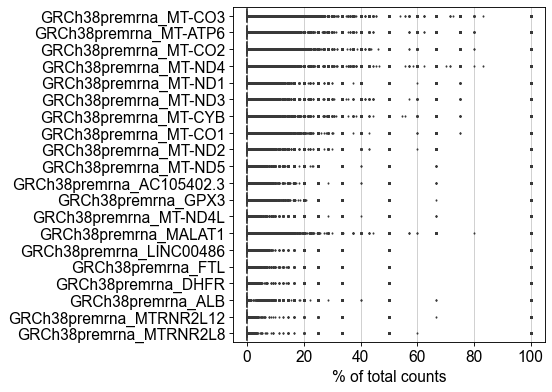

In [367]:
sc.pl.highest_expr_genes(D8_premrna, n_top=20, )

Basic filtering:

In [368]:
sc.pp.filter_cells(D8_premrna, min_genes=200)
sc.pp.filter_genes(D8_premrna, min_cells=3)

filtered out 2619808 cells that have less than 200 genes expressed
filtered out 7491 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [369]:
D8_premrna.var['mt'] = D8_premrna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(D8_premrna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

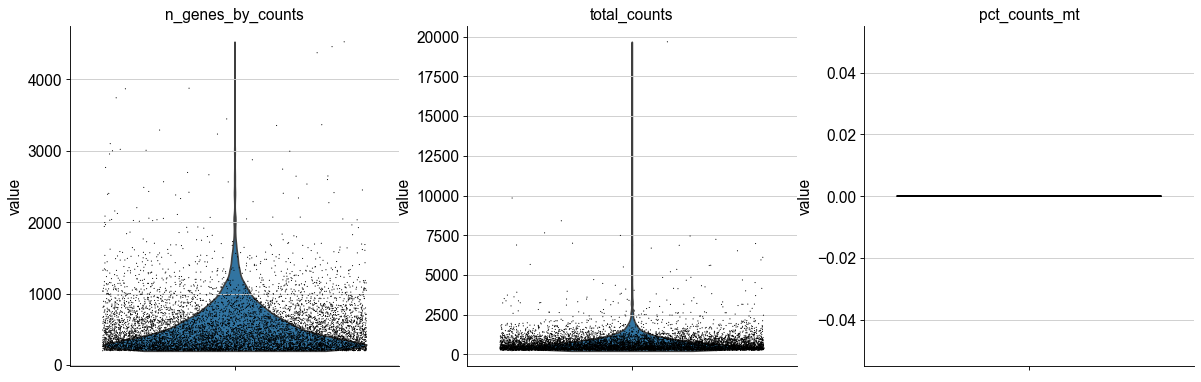

In [370]:
sc.pl.violin(D8_premrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

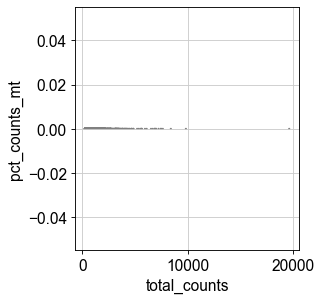

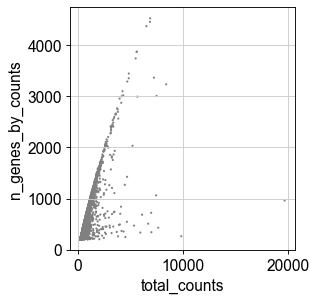

In [371]:
sc.pl.scatter(D8_premrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(D8_premrna, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [372]:
D8_premrna = D8_premrna[D8_premrna.obs.n_genes_by_counts < 2500, :]
D8_premrna = D8_premrna[D8_premrna.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [373]:
sc.pp.normalize_total(D8_premrna, target_sum=1e4)

/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [374]:
sc.pp.log1p(D8_premrna)

Identify highly-variable genes.

In [375]:
sc.pp.highly_variable_genes(D8_premrna, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


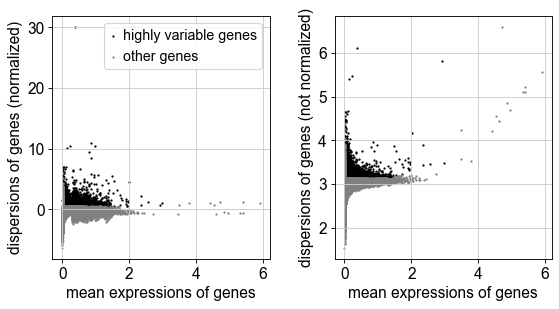

In [376]:
sc.pl.highly_variable_genes(D8_premrna)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [377]:
D8_premrna.raw = D8_premrna

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [378]:
D8_premrna = D8_premrna[:, D8_premrna.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [379]:
sc.pp.regress_out(D8_premrna, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [380]:
sc.pp.scale(D8_premrna, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [381]:
sc.tl.pca(D8_premrna, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

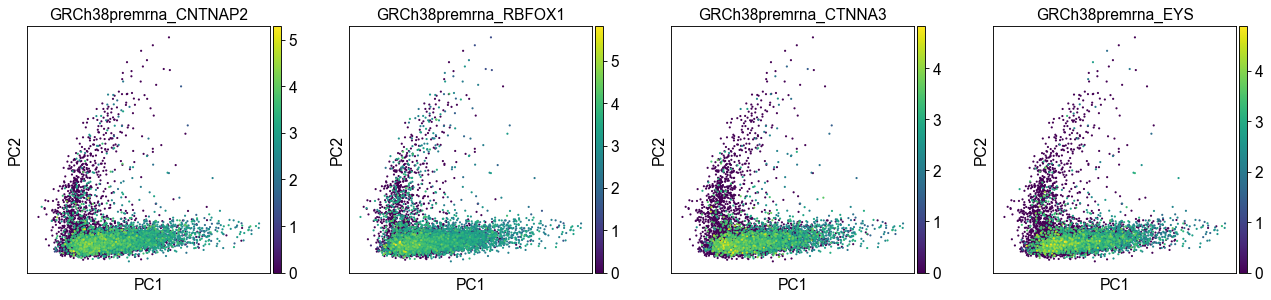

In [382]:
sc.pl.pca(D8_premrna, color=['GRCh38premrna_CNTNAP2', 'GRCh38premrna_RBFOX1', 'GRCh38premrna_CTNNA3', 'GRCh38premrna_EYS'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(results_file)

In [ ]:
adata

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [383]:
sc.pp.neighbors(D8_premrna, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [384]:
sc.tl.umap(D8_premrna)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


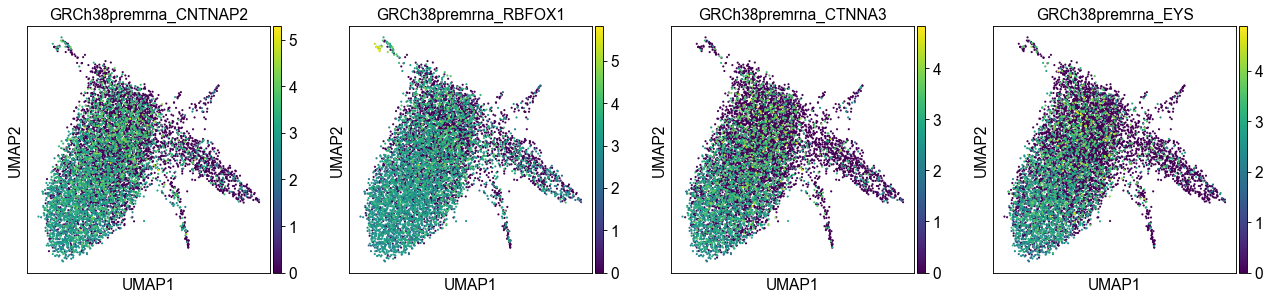

In [385]:
sc.pl.umap(D8_premrna, color=['GRCh38premrna_CNTNAP2', 'GRCh38premrna_RBFOX1', 'GRCh38premrna_CTNNA3', 'GRCh38premrna_EYS'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [386]:
sc.pl.umap(D8_premrna, color=['GRCh38premrna_CNTNAP2', 'GRCh38premrna_RBFOX1', 'GRCh38premrna_CTNNA3', 'GRCh38premrna_EYS'], use_raw=False)

KeyError: 'Could not find key GRCh38premrna_CNTNAP2 in .var_names or .obs.columns.'

<Figure size 1545.6x320 with 0 Axes>

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [387]:
sc.tl.leiden(D8_premrna)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


Plot the clusters, which agree quite well with the result of Seurat.

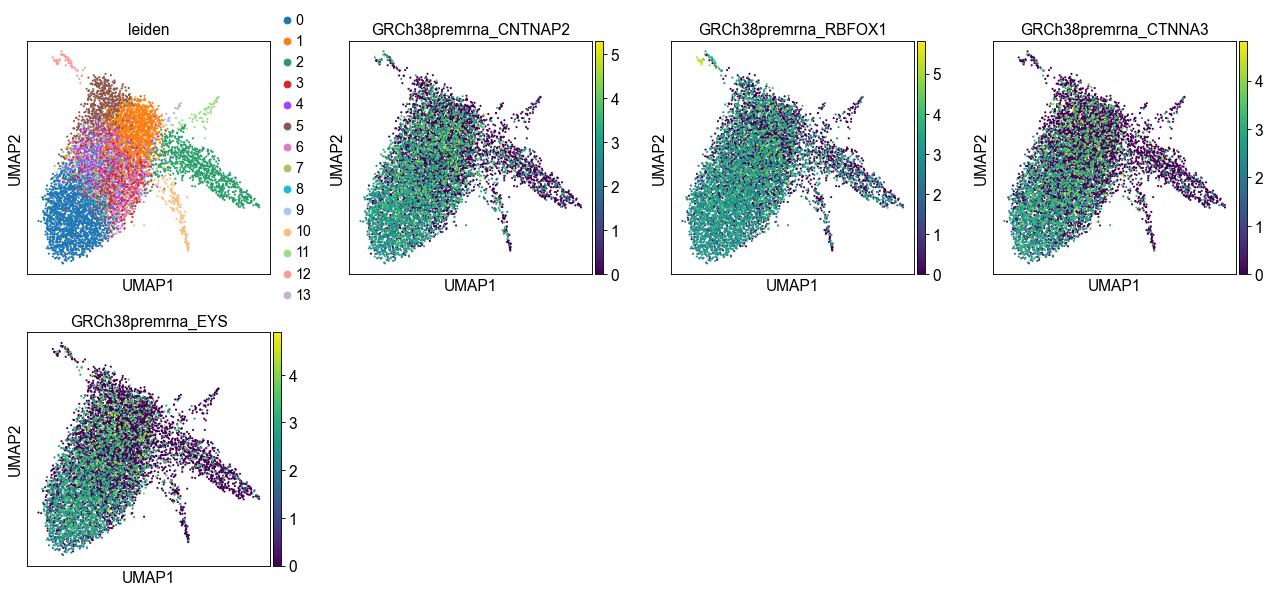

In [388]:
sc.pl.umap(D8_premrna, color=['leiden', 'GRCh38premrna_CNTNAP2', 'GRCh38premrna_RBFOX1', 'GRCh38premrna_CTNNA3', 'GRCh38premrna_EYS'])

Save the result.

In [ ]:
adata.write(results_file)

In [392]:
D4_exon

AnnData object with n_obs × n_vars = 5403 × 4327
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


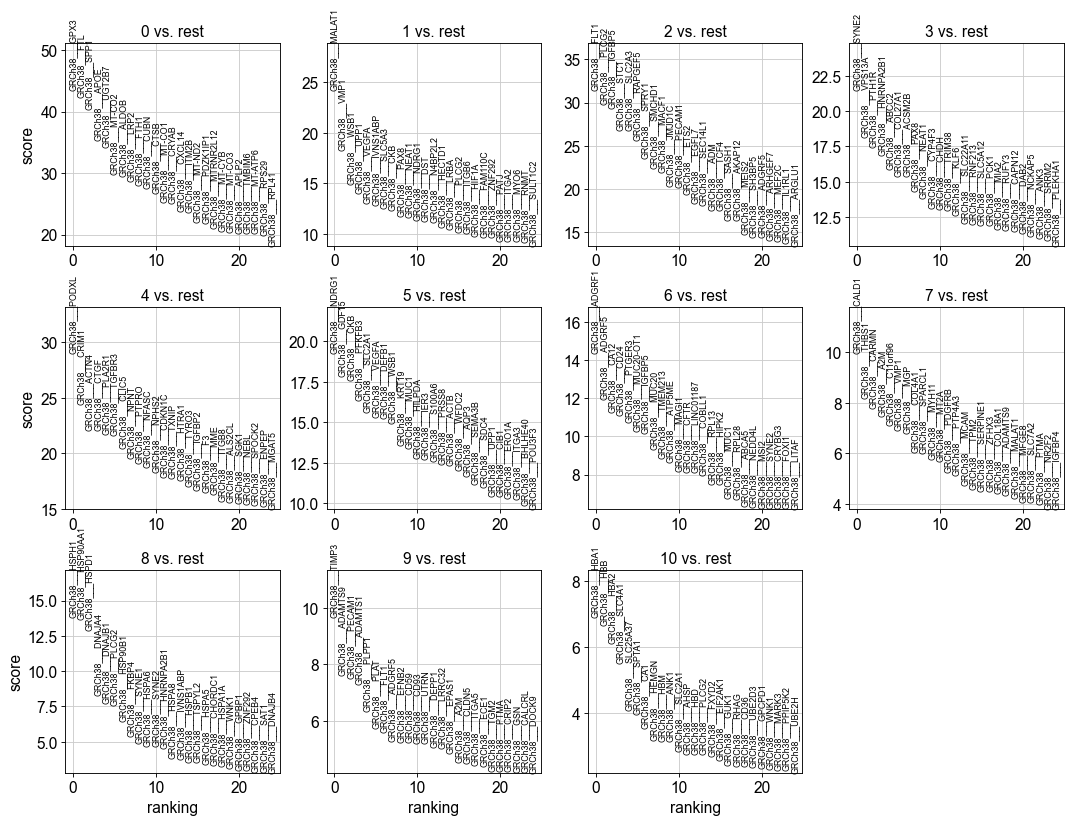

In [311]:
sc.tl.rank_genes_groups(D8_premrna, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(D8_premrna, n_genes=25, sharey=False)

Save the result.

In [ ]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:10)


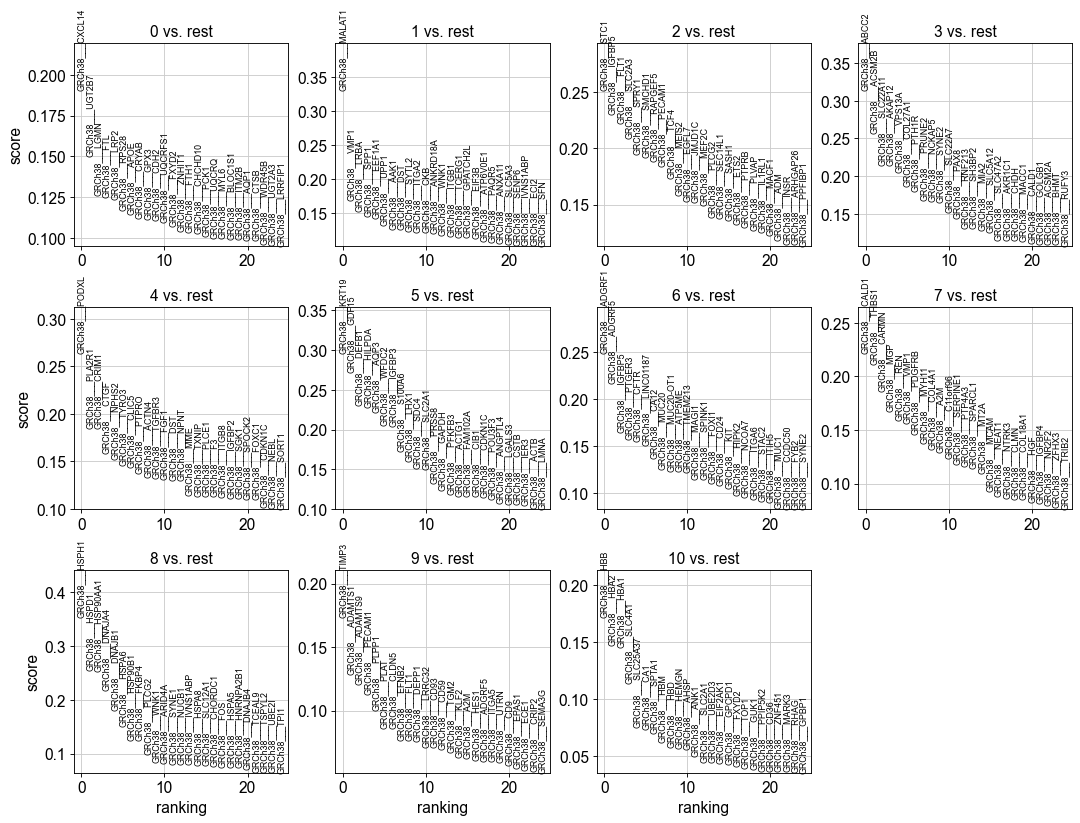

In [312]:
sc.tl.rank_genes_groups(D4_exon, 'leiden', method='logreg')
sc.pl.rank_genes_groups(D4_exon, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [7]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

KeyError: 'rank_genes_groups'

In [61]:
adata.obs['leiden']

02-P248880-S026-R01-AGACAGGCATGCCGAC    15
02-P248880-S026-R01-GGTGGCTGTATGGAAT     4
02-P248880-S026-R01-GTTGTCCAGGGAGGAC    15
02-P248880-S026-R01-GTTACGATCCCTTGGT    15
02-P248880-S026-R01-CAACCTCCACGAAAGC     4
                                        ..
13-P999994-S001-R01-CTACTATCACCCATAA     7
13-P999994-S001-R01-CTAACCCGTAGGAGTC     7
13-P999994-S001-R01-GTTACGATCCAATCTT    25
13-P999994-S001-R01-CTACAGATCCACGTGG    25
13-P999994-S001-R01-CAGCGTGTCATTCTTG     7
Name: leiden, Length: 33872, dtype: category
Categories (36, object): ['0', '1', '2', '3', ..., '32', '33', '34', '35']

In [9]:
metadata = pd.read_csv('data/SCP1214/metadata/GSE171668_kidney_metadata.csv')
metadata

,barcodes,donor,n_genes,n_counts,percent_mito,method,doublet,predicted_celltype,manual_annotation
0,02-P240970-S036-R01-AAACCCAAGAGCAACC,D4,488,906,0.000000,nuclei,False,vascular endothelial,Stressed EC
1,02-P240970-S036-R01-AAACCCAGTCTGCATA,D4,1624,3334,0.000000,nuclei,True,parietel_epithelial,PCT-S2
2,02-P240970-S036-R01-AAACCCATCTCTGGTC,D4,1040,2084,0.287908,nuclei,False,princial_collecting_duct,CNT
3,02-P240970-S036-R01-AAACGAACATGCCGAC,D4,908,1571,12.094208,nuclei,False,princial_collecting_duct,CD-PC
4,02-P240970-S036-R01-AAACGAATCAGAGTTC,D4,666,1235,0.000000,nuclei,False,vascular endothelial,Glomerular EC
...,...,...,...,...,...,...,...,...,...
33867,13-P999997-S001-R01-TTTCACAAGAGAGAAC,D30,355,467,9.421842,nuclei,False,proximal_convoluted_tubule,PCT-S2
33868,13-P999997-S001-R01-TTTCATGCAATTGCTG,D30,342,441,4.535147,nuclei,True,thin_descending_limb,PCT-S1/S2
33869,13-P999997-S001-R01-TTTCATGTCGATTCCC,D30,366,462,1.731602,nuclei,False,thick_ascending_limb,TAL
33870,13-P999997-S001-R01-TTTCCTCCACTGCGAC,D30,263,431,13.921114,nuclei,False,thick_ascending_limb,Distal Epi Doublet (PCT)


In [5]:
metadata_kidney = pd.read_table('data/SCP1214/metadata/kidney.scp.metadata.txt')
metadata_kidney = metadata_kidney[1:]
metadata_kidney

,NAME,n_genes,n_UMI,percent_mito,method,doublet,predicted_celltype,manual_annotation,donor,disease
1,02-P248880-S026-R01-AGACAGGCATGCCGAC,5135,19926,0.00,nuclei,True,podocyte,Podocyte,D5,COVID-19
2,02-P248880-S026-R01-GGTGGCTGTATGGAAT,5236,17399,0.00,nuclei,False,parietel_epithelial,tDL,D5,COVID-19
3,02-P248880-S026-R01-GTTGTCCAGGGAGGAC,4661,16131,0.00,nuclei,False,podocyte,Podocyte,D5,COVID-19
4,02-P248880-S026-R01-GTTACGATCCCTTGGT,4321,14082,0.00,nuclei,False,podocyte,Podocyte,D5,COVID-19
5,02-P248880-S026-R01-CAACCTCCACGAAAGC,4147,13239,9.62,nuclei,False,parietel_epithelial,PCT-S1/S2,D5,COVID-19
...,...,...,...,...,...,...,...,...,...,...
33868,13-P999994-S001-R01-CTACTATCACCCATAA,329,403,0.00,nuclei,False,princial_collecting_duct,CNT,D28,COVID-19
33869,13-P999994-S001-R01-CTAACCCGTAGGAGTC,316,405,0.00,nuclei,False,princial_collecting_duct,CNT,D28,COVID-19
33870,13-P999994-S001-R01-GTTACGATCCAATCTT,330,404,0.00,nuclei,False,collecting_duct_alpha,CD-IC-A,D28,COVID-19
33871,13-P999994-S001-R01-CTACAGATCCACGTGG,314,401,0.00,nuclei,False,collecting_duct_alpha,CD-IC-B,D28,COVID-19


In [394]:
metadata_liver = pd.read_table('data/SCP1213/metadata/liver.scp.metadata.txt')
metadata_liver.head(5)

,NAME,n_genes,n_UMI,percent_mito,method,doublet,predicted_celltype,manual_annotation,donor,disease
0,TYPE,numeric,numeric,numeric,group,group,group,group,group,group
1,02-P166169-S109-R01-GAGAGGTAGTACAGAT,277,1767,2.26,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
2,02-P166169-S109-R01-GAGGGATTCACGGTCG,1010,2380,8.19,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
3,02-P166169-S109-R01-GGAGGATCAGGAGGTT,510,1118,3.58,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
4,02-P166169-S109-R01-ATCCTATAGTTTGGCT,1050,1441,0.07,nuclei,False,hepatocyte,CP+Periportal hepatocytes,D3_1,COVID-19


In [304]:
donors = metadata['donor'].unique()
technical_cells = metadata[metadata['manual_annotation'].str.contains('Technical/muscle')]
clusters = technical_cells['manual_annotation'].unique()
#metadata.loc[metadata['manual_annotation'] == 'Technical/muscle', 'manual_annotation'].iloc[0]
donor_clusters = pd.DataFrame(0.0, donors, clusters)

In [305]:
for index, row in technical_cells.iterrows():
    current_donor = row['donor']
    #current_donor = metadata.loc[metadata['barcodes'] == sample, 'donor'].iloc[0]
    current_cluster = row['manual_annotation']
    donor_clusters.at[current_donor, current_cluster] += 1.0
donor_clusters

,Technical/muscle (Mes),Technical/muscle (Imm),Technical/muscle (PCT),Technical/muscle (EC),Technical/muscle
D4,391.0,53.0,30.0,36.0,5.0
D5,1.0,3.0,11.0,1.0,2.0
D6,1.0,0.0,0.0,0.0,0.0
D7,112.0,9.0,17.0,14.0,5.0
D8,1276.0,288.0,148.0,139.0,151.0
D10,0.0,0.0,10.0,0.0,0.0
D11,0.0,0.0,24.0,0.0,0.0
D12,19.0,2.0,0.0,0.0,0.0
D14,1.0,0.0,11.0,0.0,0.0
D15,0.0,2.0,16.0,2.0,0.0


In [313]:
liver_donors = metadata_liver['donor'].unique()
liver_donors = liver_donors[1:]
liver_technical_cells = metadata_liver[metadata_liver['manual_annotation'].str.contains('Technial/Muscle')]
liver_clusters = liver_technical_cells['manual_annotation'].unique()
#metadata.loc[metadata['manual_annotation'] == 'Technical/muscle', 'manual_annotation'].iloc[0]
liver_donor_clusters = pd.DataFrame(0.0, liver_donors, liver_clusters)

In [314]:
for index, row in liver_technical_cells.iterrows():
    current_donor = row['donor']
    #current_donor = metadata.loc[metadata['barcodes'] == sample, 'donor'].iloc[0]
    current_cluster = row['manual_annotation']
    liver_donor_clusters.at[current_donor, current_cluster] += 1.0
liver_donor_clusters

,Technial/Muscle (Imm),Technial/Muscle (EC),Technial/Muscle (Hep),Technial/Muscle (Mes)
D3_1,0.0,0.0,0.0,0.0
D5,4.0,3.0,9.0,1.0
D1,1.0,1.0,14.0,0.0
D2,141.0,21.0,103.0,70.0
D3_2,0.0,0.0,11.0,0.0
D4,57.0,5.0,71.0,13.0
D6,0.0,0.0,1.0,0.0
D7,2.0,0.0,74.0,6.0
D10,356.0,28.0,237.0,100.0
D11,10.0,16.0,135.0,27.0


In [316]:
D10_only = metadata_liver[metadata_liver['donor'] == 'D10']
D10_only

,NAME,n_genes,n_UMI,percent_mito,method,doublet,predicted_celltype,manual_annotation,donor,disease
5450,04-P054921-S080-R01-GGCTTTCGTTAGTTCG,4785,19249,0.00,nuclei,False,vascular endothelial,LSEC-Z1,D10,COVID-19
5451,04-P054921-S080-R01-ACGTAGTTCAGACATC,5096,19042,0.00,nuclei,False,cholangiocyte,Cholangiocytes,D10,COVID-19
5452,04-P054921-S080-R01-CCCTCTCGTCAACGCC,4795,18221,0.00,nuclei,False,cholangiocyte,Cholangiocytes,D10,COVID-19
5453,04-P054921-S080-R01-TTCACGCCAAGAGATT,4240,13909,0.00,nuclei,False,cholangiocyte,Cholangiocytes,D10,COVID-19
5454,04-P054921-S080-R01-ACAACCAGTCCATACA,4308,13568,0.00,nuclei,False,cholangiocyte,Cholangiocytes,D10,COVID-19
...,...,...,...,...,...,...,...,...,...,...
7465,04-P054921-S080-R01-GGGCTCAAGTAAGCAT,364,403,0.00,nuclei,False,vascular endothelial,CP+Periportal hepatocytes,D10,COVID-19
7466,04-P054921-S080-R01-GTCCCATTCTAGTCAG,379,402,0.00,nuclei,False,vascular endothelial,CP+Periportal hepatocytes,D10,COVID-19
7467,04-P054921-S080-R01-TGGGAGAAGTGTACCT,367,402,0.00,nuclei,False,vascular endothelial,CP+Periportal hepatocytes,D10,COVID-19
7468,04-P054921-S080-R01-AGTCTCCGTTCGATTG,365,402,0.00,nuclei,False,vascular endothelial,Technial/Muscle (Imm),D10,COVID-19


In [301]:
D4_only = metadata[metadata['donor'] == 'D4']
Mes_names = D4_only.loc[D4_only['manual_annotation'] == 'Technical/muscle (Mes)', 'barcodes'].to_list()
Imm_names = D4_only.loc[D4_only['manual_annotation'] == 'Technical/muscle (Imm)', 'barcodes'].to_list()
PCT_names = D4_only.loc[D4_only['manual_annotation'] == 'Technical/muscle (PCT)', 'barcodes'].to_list()
EC_names = D4_only.loc[D4_only['manual_annotation'] == 'Technical/muscle (EC)', 'barcodes'].to_list()
None_names = D4_only.loc[D4_only['manual_annotation'] == 'Technical/muscle', 'barcodes'].to_list()

In [205]:
D4_D8 = metadata[(metadata['donor'] == 'D4') | (metadata['donor'] == 'D8')]
all_tech_names = D4_D8.loc[(D4_D8['manual_annotation'] == 'Technical/muscle (Mes)') | (D4_D8['manual_annotation'] == 'Technical/muscle (Imm)') |
                      (D4_D8['manual_annotation'] == 'Technical/muscle (PCT)') | (D4_D8['manual_annotation'] == 'Technical/muscle (EC)') |
                      (D4_D8['manual_annotation'] == 'Technical/muscle'), 'barcodes'].to_list()

In [146]:
four = adata[adata.obs.index.str.contains('04-P006354-S023-R01')]
four

View of AnnData object with n_obs × n_vars = 3393 × 30287
    var: 'gene_ids'

In [295]:
len(Mes_names)

391

In [296]:
len(Imm_names)

53

In [297]:
len(PCT_names)

30

In [298]:
len(EC_names)

36

In [299]:
len(None_names)

5

In [300]:
len(all_tech_names)

2517

In [89]:
adata.obs['barcodes']

0        02-P240970-S036-R01-AAACCCAAGAGCAACC
1        02-P240970-S036-R01-AAACCCAGTCTGCATA
2        02-P240970-S036-R01-AAACCCATCTCTGGTC
3        02-P240970-S036-R01-AAACGAACATGCCGAC
4        02-P240970-S036-R01-AAACGAATCAGAGTTC
                         ...                 
33867    13-P999997-S001-R01-TTTCACAAGAGAGAAC
33868    13-P999997-S001-R01-TTTCATGCAATTGCTG
33869    13-P999997-S001-R01-TTTCATGTCGATTCCC
33870    13-P999997-S001-R01-TTTCCTCCACTGCGAC
33871    13-P999997-S001-R01-TTTGATCTCGTGACTA
Name: barcodes, Length: 33872, dtype: object

In [170]:
D4_exon_barcodes = D4_exon.obs.index.tolist()
for i in range(len(D4_exon_barcodes)):
    D4_exon_barcodes[i] = '02-P240970-S036-R01-' + D4_exon_barcodes[i].removesuffix('-1')
D4_exon_barcodes = pd.DataFrame(D4_exon_barcodes)[0]

In [184]:
D4_exon.obs

""
AAACCCAAGAGCAACC-1
AAACCCAGTCTGCATA-1
AAACCCATCTCTGGTC-1
AAACGAACATGCCGAC-1
AAACGAATCAAGCCAT-1
...
TTTGGTTTCTCTGACC-1
TTTGTTGGTTGGTACT-1
TTTGTTGTCCGACAGC-1
TTTGTTGTCCTTACCG-1


In [172]:
D4_premrna_barcodes = D4_premrna.obs.index.tolist()
for i in range(len(D4_premrna_barcodes)):
    D4_premrna_barcodes[i] = '02-P240970-S036-R01-' + D4_premrna_barcodes[i].removesuffix('-1')
D4_premrna_barcodes = pd.DataFrame(D4_premrna_barcodes)[0]

In [173]:
D8_exon_barcodes = D8_exon.obs.index.tolist()
for i in range(len(D8_exon_barcodes)):
    D8_exon_barcodes[i] = '04-P006354-S023-R01-' + D8_exon_barcodes[i].removesuffix('-1')
D8_exon_barcodes = pd.DataFrame(D8_exon_barcodes)[0]

In [174]:
D8_premrna_barcodes = D8_premrna.obs.index.tolist()
for i in range(len(D8_premrna_barcodes)):
    D8_premrna_barcodes[i] = '04-P006354-S023-R01-' + D8_premrna_barcodes[i].removesuffix('-1')
D8_premrna_barcodes = pd.DataFrame(D8_premrna_barcodes)[0]

In [125]:
adata.obs

,barcodes,donor,n_genes,n_counts,percent_mito,method,doublet,predicted_celltype,manual_annotation
0,02-P240970-S036-R01-AAACCCAAGAGCAACC,D4,488,906,0.000000,nuclei,False,vascular endothelial,Stressed EC
1,02-P240970-S036-R01-AAACCCAGTCTGCATA,D4,1624,3334,0.000000,nuclei,True,parietel_epithelial,PCT-S2
2,02-P240970-S036-R01-AAACCCATCTCTGGTC,D4,1040,2084,0.287908,nuclei,False,princial_collecting_duct,CNT
3,02-P240970-S036-R01-AAACGAACATGCCGAC,D4,908,1571,12.094208,nuclei,False,princial_collecting_duct,CD-PC
4,02-P240970-S036-R01-AAACGAATCAGAGTTC,D4,666,1235,0.000000,nuclei,False,vascular endothelial,Glomerular EC
...,...,...,...,...,...,...,...,...,...
33867,13-P999997-S001-R01-TTTCACAAGAGAGAAC,D30,355,467,9.421842,nuclei,False,proximal_convoluted_tubule,PCT-S2
33868,13-P999997-S001-R01-TTTCATGCAATTGCTG,D30,342,441,4.535147,nuclei,True,thin_descending_limb,PCT-S1/S2
33869,13-P999997-S001-R01-TTTCATGTCGATTCCC,D30,366,462,1.731602,nuclei,False,thick_ascending_limb,TAL
33870,13-P999997-S001-R01-TTTCCTCCACTGCGAC,D30,263,431,13.921114,nuclei,False,thick_ascending_limb,Distal Epi Doublet (PCT)


In [234]:
Mes = adata[adata.obs['barcodes'].isin(Mes_names)]
Imm = adata[adata.obs['barcodes'].isin(Imm_names)]
PCT = adata[adata.obs['barcodes'].isin(PCT_names)]
EC = adata[adata.obs['barcodes'].isin(EC_names)]
Non = adata[adata.obs['barcodes'].isin(None_names)]

In [386]:
current_subset = adata[
    #((adata.obs['donor'] == 'D4') | (adata.obs['donor'] == 'D8')) & 
                 ((adata.obs['manual_annotation'] == 'Technical/muscle'))]
                  #| (adata.obs['manual_annotation'] == 'Technical/muscle (Imm)') |
                  #    (adata.obs['manual_annotation'] == 'Technical/muscle (PCT)') | (adata.obs['manual_annotation'] == 'Technical/muscle (EC)') |
                  #    (adata.obs['manual_annotation'] == 'Technical/muscle'))]
current_subset

View of AnnData object with n_obs × n_vars = 164 × 30287
    obs: 'barcodes', 'donor', 'n_genes', 'n_counts', 'percent_mito', 'method', 'doublet', 'predicted_celltype', 'manual_annotation'
    var: 'gene_ids'
    obsm: 'X_pca'

In [216]:
all_tech = adata[adata.obs['barcodes'].isin(all_tech_names)]
all_tech

View of AnnData object with n_obs × n_vars = 2517 × 30287
    obs: 'barcodes', 'donor', 'n_genes', 'n_counts', 'percent_mito', 'method', 'doublet', 'predicted_celltype', 'manual_annotation'
    var: 'gene_ids'
    obsm: 'X_pca'

In [323]:
adata_liver

,NAME,n_genes,n_UMI,percent_mito,method,doublet,predicted_celltype,manual_annotation,donor,disease
0,TYPE,numeric,numeric,numeric,group,group,group,group,group,group
1,02-P166169-S109-R01-GAGAGGTAGTACAGAT,277,1767,2.26,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
2,02-P166169-S109-R01-GAGGGATTCACGGTCG,1010,2380,8.19,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
3,02-P166169-S109-R01-GGAGGATCAGGAGGTT,510,1118,3.58,nuclei,False,hepatocyte,APOA1+APOA2+TTR+Hepatocyte-1,D3_1,COVID-19
4,02-P166169-S109-R01-ATCCTATAGTTTGGCT,1050,1441,0.07,nuclei,False,hepatocyte,CP+Periportal hepatocytes,D3_1,COVID-19
...,...,...,...,...,...,...,...,...,...,...
46997,12-P890292-S003-R01-GGGACAACAAACACCT,344,422,0.95,nuclei,False,macrophage,Monocyte,D17,COVID-19
46998,12-P890292-S003-R01-ATTCCCGTCTGGGTCG,306,412,0.00,nuclei,False,vascular endothelial,LSEC-Z23,D17,COVID-19
46999,12-P890292-S003-R01-CTGCGAGTCGCCATAA,357,408,0.00,nuclei,False,vascular endothelial,Cholangiocytes,D17,COVID-19
47000,12-P890292-S003-R01-AGTAACCTCATTTCCA,378,471,0.64,nuclei,False,macrophage,CP+Periportal hepatocytes,D17,COVID-19


In [374]:
liver_subset = adata_liver[
    #(adata_liver.obs['donor'] == 'D10') &
                 ((adata_liver.obs['manual_annotation'] == 'Technial/Muscle (Hep)'))]
    #              | (adata_liver.obs['manual_annotation'] == 'Technial/Muscle (EC)') |
    #                  (adata_liver.obs['manual_annotation'] == 'Technial/Muscle (Hep)') | (adata_liver.obs['manual_annotation'] == 'Technial/Muscle (Mes)'))]
liver_subset

View of AnnData object with n_obs × n_vars = 1101 × 30015
    obs: 'NAME', 'n_genes', 'n_UMI', 'percent_mito', 'method', 'doublet', 'predicted_celltype', 'manual_annotation', 'donor', 'disease'
    var: 'gene_ids'

/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
normalizing counts per cell
    finished (0:00:00)


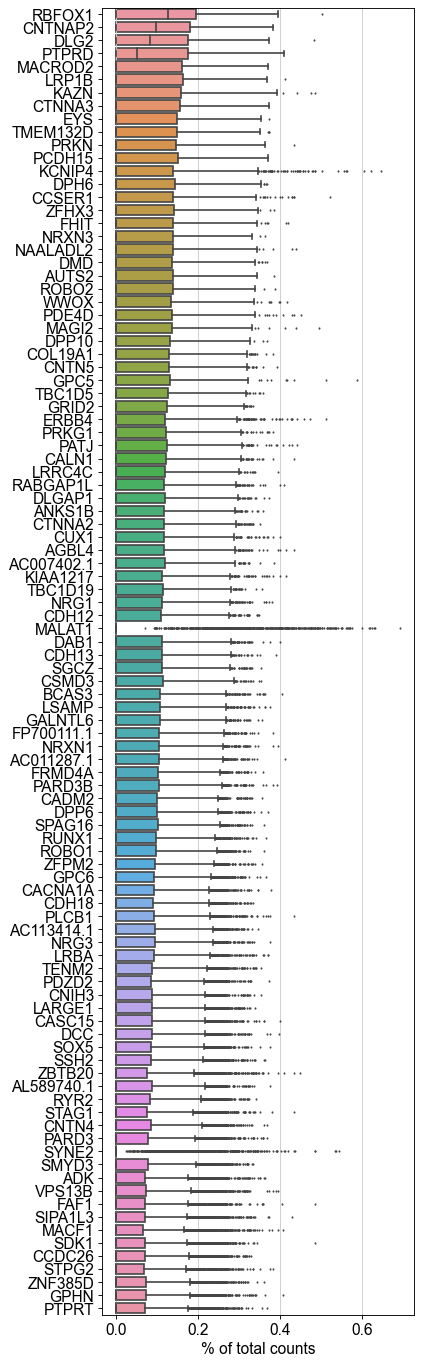

In [8]:
sc.pl.highest_expr_genes(adata[adata.obs['donor'] == 'D8'], n_top=100, )

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'doublet' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'manual_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'disease' as categorical


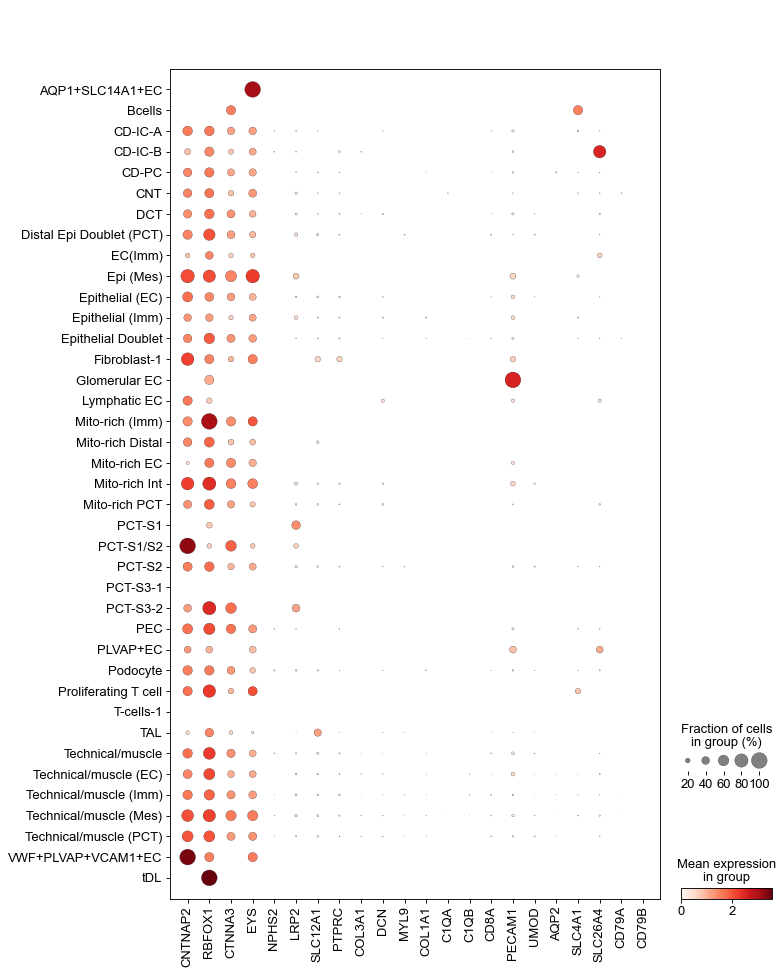

In [13]:
sc.pl.dotplot(adata[adata.obs['donor'] == 'D8'], var_names=['CNTNAP2', 'RBFOX1', 'CTNNA3', 'EYS', 'NPHS2', 'LRP2', 'SLC12A1', 'PTPRC', 'COL3A1', 'DCN', 'MYL9', 'COL1A1', 'C1QA', 'C1QB', 'CD8A', 'PECAM1', 'UMOD', 'AQP2', 'SLC4A1', 'SLC26A4', 'CD79A', 'CD79B'], groupby='manual_annotation')

In [418]:
D4_exon_matched

AnnData object with n_obs × n_vars = 3987 × 33567
    obs: 'NAME', 'n_genes', 'n_UMI', 'percent_mito', 'method', 'doublet', 'predicted_celltype', 'manual_annotation', 'donor', 'disease'
    var: 'gene_ids'

In [423]:
breakup = {}
for i in D8_premrna_matched.obs['manual_annotation']:
    if i in breakup:
        breakup[i] += 1
    else:
        breakup[i] = 1
breakup
#check breakup of cells by cell type

{'DCT': 131,
 'Technical/muscle (Mes)': 1276,
 'CD-PC': 161,
 'Technical/muscle (PCT)': 148,
 'TAL': 202,
 'CD-IC-A': 76,
 'Epithelial Doublet': 232,
 'Technical/muscle (Imm)': 288,
 'Technical/muscle': 151,
 'Mito-rich EC': 8,
 'Epithelial (EC)': 79,
 'PEC': 43,
 'Technical/muscle (EC)': 139,
 'Mito-rich Distal': 11,
 'CD-IC-B': 38,
 'Epi (Mes)': 11,
 'CNT': 51,
 'Distal Epi Doublet (PCT)': 62,
 'PCT-S1': 11,
 'Podocyte': 78,
 'Mito-rich PCT': 38,
 'Proliferating T cell': 4,
 'Fibroblast-1': 4,
 'PCT-S2': 62,
 'Mito-rich Int': 24,
 'Epithelial (Imm)': 26,
 'Bcells': 2,
 'PCT-S1/S2': 5,
 'tDL': 1,
 'VWF+PLVAP+VCAM1+EC': 2,
 'PCT-S3-2': 5,
 'PLVAP+EC': 3,
 'EC(Imm)': 5,
 'Glomerular EC': 2,
 'Lymphatic EC': 8,
 'PCT-S3-1': 2,
 'T-cells-1': 1,
 'Mito-rich (Imm)': 2,
 'AQP1+SLC14A1+EC': 1}

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'method' as categorical
... storing 'doublet' as categorical
... storing 'predicted_celltype' as categorical
... storing 'manual_annotation' as categorical
... storing 'donor' as categorical
... storing 'disease' as categorical


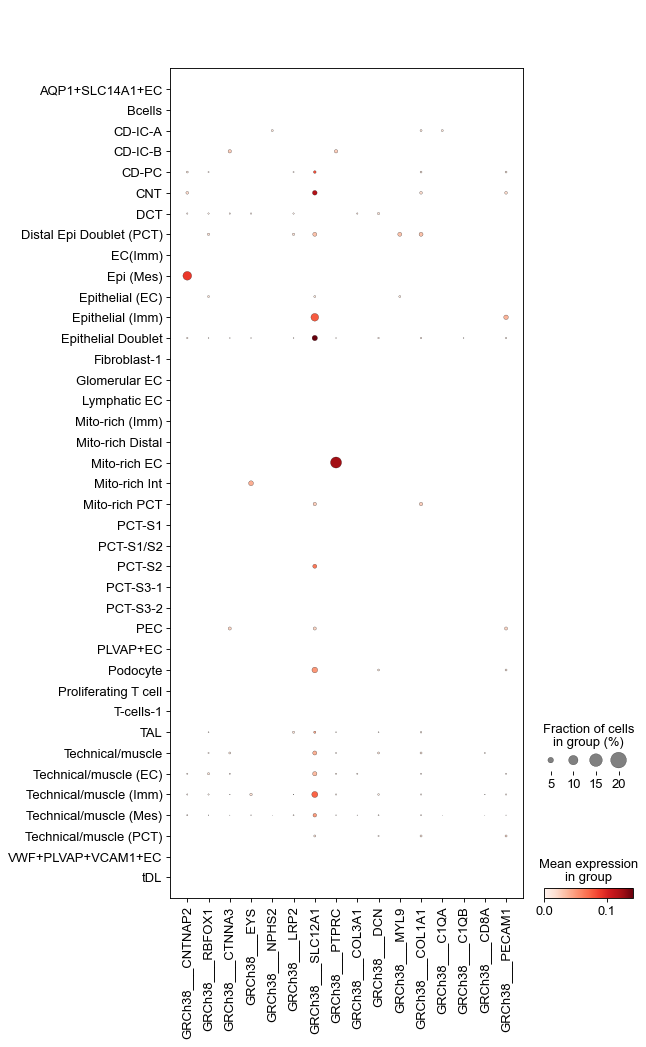

In [39]:
sc.pl.dotplot(D8_exon_matched, var_names=['GRCh38___CNTNAP2', 'GRCh38___RBFOX1', 'GRCh38___CTNNA3', 'GRCh38___EYS', 'GRCh38___NPHS2', 'GRCh38___LRP2', 'GRCh38___SLC12A1', 'GRCh38___PTPRC', 'GRCh38___COL3A1', 'GRCh38___DCN', 'GRCh38___MYL9', 'GRCh38___COL1A1', 'GRCh38___C1QA', 'GRCh38___C1QB', 'GRCh38___CD8A', 'GRCh38___PECAM1'], groupby='manual_annotation')

In [22]:
metadata_liver


,barcodes,donor,n_genes,n_counts,percent_mito,method,doublet,predicted_celltype,manual_annotation
0,02-P240970-S036-R01-AAACCCAAGAGCAACC,D4,488,906,0.000000,nuclei,False,vascular endothelial,Stressed EC
1,02-P240970-S036-R01-AAACCCAGTCTGCATA,D4,1624,3334,0.000000,nuclei,True,parietel_epithelial,PCT-S2
2,02-P240970-S036-R01-AAACCCATCTCTGGTC,D4,1040,2084,0.287908,nuclei,False,princial_collecting_duct,CNT
3,02-P240970-S036-R01-AAACGAACATGCCGAC,D4,908,1571,12.094208,nuclei,False,princial_collecting_duct,CD-PC
4,02-P240970-S036-R01-AAACGAATCAGAGTTC,D4,666,1235,0.000000,nuclei,False,vascular endothelial,Glomerular EC
...,...,...,...,...,...,...,...,...,...
33867,13-P999997-S001-R01-TTTCACAAGAGAGAAC,D30,355,467,9.421842,nuclei,False,proximal_convoluted_tubule,PCT-S2
33868,13-P999997-S001-R01-TTTCATGCAATTGCTG,D30,342,441,4.535147,nuclei,True,thin_descending_limb,PCT-S1/S2
33869,13-P999997-S001-R01-TTTCATGTCGATTCCC,D30,366,462,1.731602,nuclei,False,thick_ascending_limb,TAL
33870,13-P999997-S001-R01-TTTCCTCCACTGCGAC,D30,263,431,13.921114,nuclei,False,thick_ascending_limb,Distal Epi Doublet (PCT)


In [10]:
adata.obs[["n_genes", "n_UMI", "percent_mito"]] = adata.obs[["n_genes", "n_UMI", "percent_mito"]].apply(pd.to_numeric)

In [441]:
import anndata as ad

... storing 'predicted_celltype' as categorical
... storing 'manual_annotation' as categorical
... storing 'donor' as categorical


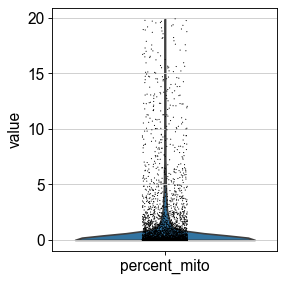

In [453]:
sc.pl.violin(ad.concat([D4_premrna_matched,D8_premrna_matched]), 'percent_mito', figsize=[3, 30])

In [430]:
clusters = adata[((adata.obs['donor'] == 'D4') | (adata.obs['donor'] == 'D8'))]

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'manual_annotation' as categorical


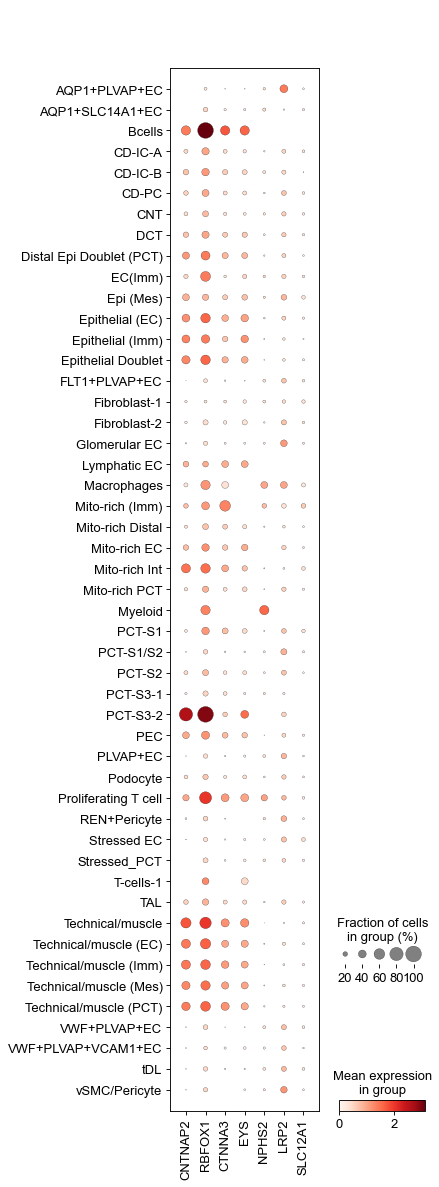

In [282]:
sc.pl.dotplot(clusters, var_names=['CNTNAP2', 'RBFOX1', 'CTNNA3', 'EYS', 'NPHS2', 'LRP2', 'SLC12A1'], groupby='manual_annotation')

In [137]:
Non.obs['batch']

04-P006354-S023-R01-AAAGGGCCAAGAGTTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    0
04-P006354-S023-R01-AAAGGGCCATGACAAA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0      0
04-P006354-S023-R01-AAAGTCCCAACCAATC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0

In [11]:
donor_clusters.values.sum()

2877.0

In [111]:
donor_clusters.to_csv('donor_technical_clusters.csv')

In [12]:
D4_ranking = adata[adata['donor'] == 'D4']
D4_ranking

KeyError: 'donor'

In [155]:
D_4_8 = adata[adata.obs_names.str.startswith('02-P240970-S036-R01'), :].concatenate(adata[adata.obs_names.str.startswith('04-P006354-S023-R01'), :])
D_4_8 = D_4_8[:, D_4_8.var_names.str.match('CNTNAP2')]
D_4_8

View of AnnData object with n_obs × n_vars = 7380 × 1
    obs: 'leiden', 'batch'
    var: 'gene_ids'
    obsm: 'X_pca', 'X_umap'

In [167]:
pd.DataFrame(D_4_8, D_4_8.obs_names.tolist(), D_4_8.var_names.tolist())

KeyboardInterrupt: 

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster: 

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )